In [1]:
## SET UP AND IMPORTS 
import pandas as pd
import requests
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import finqual as fq
import spacy
import os
import time
import joblib
import glob
import wrds
from yahoofinancials import YahooFinancials
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from datetime import timedelta
from collections import defaultdict

In [2]:
## LOAD DATA 

df = pd.read_csv('earnings_calls_speaker_2018_current.csv') #transcript data
# Drop duplicate ticker column if both are identical
df = df.loc[:, ~df.columns.duplicated()]

# Make sure column names are clean
df.columns = df.columns.str.strip()

# Convert mostImportantDateUTC to datetime
df['mostImportantDateUTC'] = pd.to_datetime(df['mostImportantDateUTC'])


# Load the GVKEY to ticker crosswalk
gvkey_ticker = pd.read_csv('merged_wrds_gvkey_V2.txt', sep='\t')

# Load the dictionary CSV
lm_dict = pd.read_csv('Loughran-McDonald_MasterDictionary_1993-2024.csv')


In [3]:
## DATA PREPARATION

# === Merge ticker info and clean ===
# Merge gvkey → ticker
df = df.merge(gvkey_ticker[['gvkey', 'tic']], on='gvkey', how='left')

# Rename 'tic' to 'ticker'
df.rename(columns={'tic': 'ticker'}, inplace=True)

# Remove any duplicate columns after merge
df = df.loc[:, ~df.columns.duplicated()]

# Standardize ticker: strip spaces, convert to uppercase
df['ticker'] = df['ticker'].astype(str).str.upper().str.strip()

# Convert earnings call date to datetime (naive, no timezone)
df['mostImportantDateUTC'] = pd.to_datetime(df['mostImportantDateUTC']).dt.tz_localize(None)

# Optional: remove invalid tickers (like empty strings or those starting with '$')
df = df[df['ticker'].notna() & ~df['ticker'].str.startswith('$')]

In [3]:
## DATA PREPROCESSING

# Load English spaCy model
nlp = spacy.load("en_core_web_sm")

# 1. Load a sample of the CSV
sample_df = pd.read_csv('earnings_calls_speaker_2018_current.csv', nrows=10000)

# 2. Filter for rows where transcriptComponentTypeId == 2.0
filtered_df = sample_df[sample_df['transcriptComponentTypeId'] == 4.0].copy()

# 3. Define the cleaning function — preserve important negations
def split_and_clean_sentences(text):
    doc = nlp(text)
    cleaned_sentences = []

    for sent in doc.sents:
        tokens = []
        for token in sent:
            if token.is_space:
                continue
            # Keep negations and relevant words; remove stopwords except 'not', 'no', 'never'
            if token.is_alpha or token.text in {"n't", "not", "no", "never"}:
                if not token.is_stop or token.text in {"n't", "not", "no", "never"}:
                    tokens.append(token.lemma_.lower())
        if tokens:
            cleaned_sentences.append(" ".join(tokens))

    return cleaned_sentences

# 4. Apply the function to your column
filtered_df['sentences'] = filtered_df['componentText'].astype(str).apply(split_and_clean_sentences)

# 5. Inspect results
print(filtered_df[['componentText', 'sentences']].head())

# Map transcript date to fiscal quarter
def get_fiscal_quarter(date):
    month = date.month
    year = date.year
    if month in [1, 2, 3]:
        return year, 1
    elif month in [4, 5, 6]:
        return year, 2
    elif month in [7, 8, 9]:
        return year, 3
    else:
        return year, 4

df[['fiscal_year', 'fiscal_quarter']] = df['mostImportantDateUTC'].apply(lambda d: pd.Series(get_fiscal_quarter(d)))


                                        componentText  \
7   Sure, Ken. It's John. I wouldn't describe the ...   
9   John again. Really the growth in the parts bus...   
12  Yes, so we don't have a sale, per se, at this ...   
14                                      Yes, correct.   
16  We're seeing good growth in our businesses. An...   

                                            sentences  
7   [sure ken, john, not describe ramp slow, descr...  
9   [john, growth part business board trading engi...  
12  [yes not sale se moment, put business sale, co...  
14                                      [yes correct]  
16  [see good growth business, feel good prospect ...  


In [5]:
## SENTIMENT ANALYSIS

# Ensure column names are capitalized properly
lm_dict.columns = lm_dict.columns.str.upper()

# Convert words to lowercase for matching
lm_dict['WORD'] = lm_dict['WORD'].str.lower()

# Extract relevant word sets
lm_positive = set(lm_dict[lm_dict['POSITIVE'] > 0]['WORD'])
lm_negative = set(lm_dict[lm_dict['NEGATIVE'] > 0]['WORD'])
lm_uncertainty = set(lm_dict[lm_dict['UNCERTAINTY'] > 0]['WORD'])
lm_litigious = set(lm_dict[lm_dict['LITIGIOUS'] > 0]['WORD'])

# define sentiment labeling function 
nlp = spacy.load("en_core_web_sm")

def label_sentiment_spacy(text):
    doc = nlp(text.strip())
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]

    pos_count = sum(token in lm_positive for token in tokens)
    neg_count = sum(token in lm_negative for token in tokens)

    if pos_count > neg_count:
        return 'positive'
    elif neg_count > pos_count:
        return 'negative'
    else:
        return 'neutral'

filtered_df['sentiment'] = filtered_df['sentences'].apply(
    lambda sentences_list: [label_sentiment_spacy(sentence) for sentence in sentences_list]
)

In [6]:
## FEATURE ENGINEERING WITH TF-IDF

# SPLIT DATA INTO TESTING AND TRAINING SETS

# Label sentiment for each sentence in the list
filtered_df['sentiment'] = filtered_df['sentences'].apply(
    lambda sents: [label_sentiment_spacy(sent) for sent in sents]
)

# 1. Explode both 'sentences' and 'sentiment' columns together
filtered_df_exploded = filtered_df.explode(['sentences', 'sentiment']).reset_index(drop=True)

# 2. Ensure sentences are strings and drop NaNs
filtered_df_exploded['sentences'] = filtered_df_exploded['sentences'].astype(str)
filtered_df_exploded = filtered_df_exploded.dropna(subset=['sentences', 'sentiment'])

# 3. Split into train/test sets BEFORE TF-IDF
from sklearn.model_selection import train_test_split

X = filtered_df_exploded['sentences']
y = filtered_df_exploded['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# CONVERTING TO NUMERICAL FEATURES USING TF-IDF

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


              precision    recall  f1-score   support

    negative       0.93      0.77      0.84       555
     neutral       0.96      0.99      0.97      4774
    positive       0.96      0.94      0.95      1133

    accuracy                           0.96      6462
   macro avg       0.95      0.90      0.92      6462
weighted avg       0.96      0.96      0.96      6462



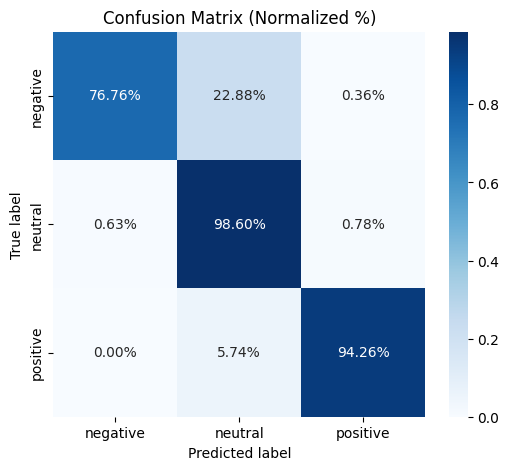

In [11]:
## MODEL TRAINING 

# Train the model
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

# predict on test set
y_pred = svm_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

# Save trained model + vectorizer
joblib.dump(vectorizer, "vectorizer.joblib")
joblib.dump(svm_model, "svm_model.joblib")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["negative", "neutral", "positive"])

# Normalize by row (so percentages per true class)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Blues", 
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix (Normalized %)")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


In [10]:
## APPLY MODEL TO FULL DATASET

vectorizer = joblib.load("vectorizer.joblib")
svm_model = joblib.load("svm_model.joblib")

batch_size = 50000
reader = pd.read_csv("earnings_calls_speaker_2018_current.csv", chunksize=batch_size)

for i, chunk in enumerate(reader):
    print(f"🔄 Processing chunk {i+1}...")
    chunk = chunk[chunk['transcriptComponentTypeId'] == 4.0].copy()
    if chunk.empty:
        continue

    chunk['sentences'] = chunk['componentText'].astype(str).apply(split_and_clean_sentences)
    chunk_exploded = chunk.explode('sentences').dropna(subset=['sentences']).reset_index(drop=True)

    X_chunk = vectorizer.transform(chunk_exploded['sentences'].astype(str))
    preds = svm_model.predict(X_chunk)
    chunk_exploded['pred_sentiment'] = preds

    # Aggregate back to transcript level
    sentiment_summary = (
        chunk_exploded.groupby(['gvkey', 'mostImportantDateUTC'])
        .agg(
            n_sentences=('sentences', 'count'),
            pos_share=('pred_sentiment', lambda x: np.mean(x == 'positive')),
            neg_share=('pred_sentiment', lambda x: np.mean(x == 'negative')),
            neu_share=('pred_sentiment', lambda x: np.mean(x == 'neutral')),
        )
        .reset_index()
    )

    sentiment_summary.to_parquet(f"sentiment_batch_{i}.parquet")


## COMBINE SENTIMENT BATCHES

files = glob.glob("sentiment_batch_*.parquet")
sentiment_all = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)
sentiment_all.to_parquet("sentiment_all.parquet")


🔄 Processing chunk 1...
🔄 Processing chunk 2...
🔄 Processing chunk 3...
🔄 Processing chunk 4...
🔄 Processing chunk 5...
🔄 Processing chunk 6...
🔄 Processing chunk 7...
🔄 Processing chunk 8...
🔄 Processing chunk 9...
🔄 Processing chunk 10...
🔄 Processing chunk 11...
🔄 Processing chunk 12...
🔄 Processing chunk 13...
🔄 Processing chunk 14...
🔄 Processing chunk 15...
🔄 Processing chunk 16...
🔄 Processing chunk 17...
🔄 Processing chunk 18...
🔄 Processing chunk 19...
🔄 Processing chunk 20...
🔄 Processing chunk 21...
🔄 Processing chunk 22...
🔄 Processing chunk 23...
🔄 Processing chunk 24...
🔄 Processing chunk 25...
🔄 Processing chunk 26...
🔄 Processing chunk 27...
🔄 Processing chunk 28...
🔄 Processing chunk 29...
🔄 Processing chunk 30...
🔄 Processing chunk 31...
🔄 Processing chunk 32...
🔄 Processing chunk 33...
🔄 Processing chunk 34...
🔄 Processing chunk 35...
🔄 Processing chunk 36...
🔄 Processing chunk 37...
🔄 Processing chunk 38...
🔄 Processing chunk 39...
🔄 Processing chunk 40...
🔄 Process

In [3]:
# Load all batches (each exploded at sentence level)
files = glob.glob("sentiment_batch_*.parquet")
sentences_all = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)

print(f"Total sentences loaded: {len(sentences_all)}")
print(sentences_all.head())

Total sentences loaded: 105884
   gvkey        mostImportantDateUTC  n_sentences  pos_share  neg_share  \
0  11264  2022-03-31 12:30:00.000000          263   0.182510   0.068441   
1  11264  2022-06-30 12:30:00.000000          400   0.250000   0.060000   
2  11301  2018-02-16 16:00:00.000000          162   0.135802   0.037037   
3  11301  2018-07-27 15:00:00.000000           82   0.134146   0.012195   
4  11301  2018-10-26 15:00:00.000000           82   0.146341   0.024390   

   neu_share  
0   0.749049  
1   0.690000  
2   0.827160  
3   0.853659  
4   0.829268  


In [6]:
## SENTIMENT METRICS

# Load the transcript-level shares file
sentences_all = pd.read_parquet("sentiment_all.parquet")

# === Derive extra metrics ===
# 1. Total sentiment score = (#pos - #neg)
sentences_all["total_sentiment_score"] = (
    sentences_all["n_sentences"] * (sentences_all["pos_share"] - sentences_all["neg_share"])
)

# 2. Average sentiment score per sentence
sentences_all["average_sentiment_score"] = (
    sentences_all["pos_share"] - sentences_all["neg_share"]
)

# 3. Sentiment ratio = (#pos - #neg) / total sentences
sentences_all["sentiment_ratio"] = sentences_all["average_sentiment_score"]

# 4. Approximate volatility (std dev of sentiment across sentences).
#    Since we only have shares, we’ll approximate using probabilities.
#    Each sentence is +1, -1, or 0 → variance = E[X^2] - (E[X])^2
#    E[X] = pos_share - neg_share
#    E[X^2] = pos_share*1^2 + neg_share*(-1)^2 + neu_share*0^2 = pos_share + neg_share
sentences_all["volatility"] = (
    (sentences_all["pos_share"] + sentences_all["neg_share"])
    - (sentences_all["average_sentiment_score"] ** 2)
) ** 0.5

# Save enriched metrics
sentences_all.to_parquet("sentiment_metrics.parquet")
sentences_all.to_csv("sentiment_summary.csv", index=False)

print(f"✅ Saved sentiment metrics for {len(sentences_all)} transcripts")
print(sentences_all.head())

✅ Saved sentiment metrics for 105884 transcripts
   gvkey        mostImportantDateUTC  n_sentences  pos_share  neg_share  \
0  11264  2022-03-31 12:30:00.000000          263   0.182510   0.068441   
1  11264  2022-06-30 12:30:00.000000          400   0.250000   0.060000   
2  11301  2018-02-16 16:00:00.000000          162   0.135802   0.037037   
3  11301  2018-07-27 15:00:00.000000           82   0.134146   0.012195   
4  11301  2018-10-26 15:00:00.000000           82   0.146341   0.024390   

   neu_share  total_sentiment_score  average_sentiment_score  sentiment_ratio  \
0   0.749049                   30.0                 0.114068         0.114068   
1   0.690000                   76.0                 0.190000         0.190000   
2   0.827160                   16.0                 0.098765         0.098765   
3   0.853659                   10.0                 0.121951         0.121951   
4   0.829268                   10.0                 0.121951         0.121951   

   volatility

In [7]:
## MODEL EVALUATION
 
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'negative', 'neutral'])

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'y_test' is not defined

In [19]:
# Load transcripts
# ==============================
df_transcripts = pd.read_csv('earnings_calls_speaker_2018_current.csv')

# Keep only transcript components with type 4.0
df_transcripts = df_transcripts[df_transcripts['transcriptComponentTypeId'] == 4.0].copy()

# ==============================
# 2️⃣ Map gvkey → ticker
# ==============================
# Assume you have a gvkey_ticker DataFrame with columns ['gvkey', 'tic']
df_transcripts = df_transcripts.merge(
    gvkey_ticker[['gvkey', 'tic']], on='gvkey', how='left'
)
df_transcripts.rename(columns={'tic': 'ticker'}, inplace=True)

# Clean ticker column
df_transcripts['ticker'] = df_transcripts['ticker'].astype(str).str.upper().str.strip()

# Convert earnings call date to datetime
df_transcripts['mostImportantDateUTC'] = pd.to_datetime(df_transcripts['mostImportantDateUTC']).dt.tz_localize(None)



In [27]:
##PRICE MOVEMENT FUNCTION - 
##finds stock price 2 trading days before and 2 trading days after the call datA accounts for non-trading days (weekends, holidays)
# === Helper: normalize tickers for Yahoo Finance ===
def normalize_ticker_for_yf(ticker):
    ticker = ticker.strip().upper()
    if '.' in ticker and ticker.count('.') == 1:
        parts = ticker.split('.')
        if parts[1].isalpha():  # e.g., BRK.A -> BRK-A
            return f"{parts[0]}-{parts[1]}"
    return ticker

# === Load delisted tickers ===
delisted_file = "delisted_tickers.csv"
if os.path.exists(delisted_file):
    delisted = set(pd.read_csv(delisted_file)['ticker'].str.upper())
else:
    delisted = set()

# === Assume df is already loaded and cleaned with 'ticker' and 'mostImportantDateUTC' ===

# === Extract unique ticker-date pairs ===
unique_calls = df[['ticker','mostImportantDateUTC']].drop_duplicates().reset_index(drop=True)
unique_calls['Price_Before'] = np.nan
unique_calls['Price_After'] = np.nan
unique_calls['Price_Pct_Change'] = np.nan

# === Process each unique ticker individually ===
tickers_to_process = unique_calls['ticker'].unique().tolist()
print(f"⏳ Processing {len(tickers_to_process)} unique tickers...")

for ticker in tickers_to_process:
    yf_ticker = normalize_ticker_for_yf(ticker)
    ticker_df = unique_calls[unique_calls['ticker'] == ticker]
    start_date = ticker_df['mostImportantDateUTC'].min() - timedelta(days=10)
    end_date = ticker_df['mostImportantDateUTC'].max() + timedelta(days=10)

    try:
        hist = yf.download(
            yf_ticker,
            start=start_date.strftime('%Y-%m-%d'),
            end=end_date.strftime('%Y-%m-%d'),
            auto_adjust=True,
            progress=False
        )
        if hist.empty:
            print(f"⚠️ No data for ticker {ticker} ({yf_ticker})")
            delisted.add(ticker)
            continue

        hist.index = hist.index.tz_localize(None)
        hist = hist.sort_index()

        for idx, row in ticker_df.iterrows():
            call_date = row['mostImportantDateUTC']
            before_dates = hist.index[hist.index < call_date]
            after_dates = hist.index[hist.index > call_date]

            if len(before_dates) >= 2 and len(after_dates) >= 2:
                day_before = before_dates[-2]
                day_after = after_dates[1]

                try:
                    # ⚡ Fix FutureWarning by using .iloc[0]
                    price_before = float(hist.loc[day_before]['Close'].iloc[0])
                    price_after = float(hist.loc[day_after]['Close'].iloc[0])

                    unique_calls.at[idx, 'Price_Before'] = price_before
                    unique_calls.at[idx, 'Price_After'] = price_after
                    unique_calls.at[idx, 'Price_Pct_Change'] = (price_after - price_before) / price_before

                except Exception as e:
                    unique_calls.at[idx, 'Price_Before'] = np.nan
                    unique_calls.at[idx, 'Price_After'] = np.nan
                    unique_calls.at[idx, 'Price_Pct_Change'] = np.nan

    except Exception as e:
        print(f"❌ Failed to download {ticker} ({yf_ticker}): {e}")
        delisted.add(ticker)

# === Save unique price movements to CSV ===
unique_calls.to_csv('price_movement.csv', index=False)
print(f"✅ Saved {len(unique_calls)} rows to price_movement.csv")

# === Merge back to full dataset ===
df = df.merge(
    unique_calls,
    on=['ticker','mostImportantDateUTC'],
    how='left',
    suffixes=('','_y')
)

df['Price_Before'] = df['Price_Before_y']
df['Price_After'] = df['Price_After_y']
df['Price_Pct_Change'] = df['Price_Pct_Change_y']
df.drop(columns=['Price_Before_y','Price_After_y','Price_Pct_Change_y'], inplace=True)

# === Save updated delisted tickers ===
safe_delisted = [t for t in delisted if isinstance(t, str)]
pd.Series(sorted(safe_delisted), name="ticker").to_csv(delisted_file, index=False)
print(f"✅ Updated delisted tickers saved to {delisted_file}")

print("✅ Price movement merge complete!")

⏳ Processing 5324 unique tickers...


HTTP Error 404: 

1 Failed download:
['0124A']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ No data for ticker 0124A (0124A)


HTTP Error 404: 

1 Failed download:
['0141A']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ No data for ticker 0141A (0141A)



1 Failed download:
['0190A']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ No data for ticker 0190A (0190A)



1 Failed download:
['1641B']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ No data for ticker 1641B (1641B)



1 Failed download:
['3SAMC']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ No data for ticker 3SAMC (3SAMC)



1 Failed download:
['3SELA']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ No data for ticker 3SELA (3SELA)



1 Failed download:
['5952B']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ No data for ticker 5952B (5952B)



1 Failed download:
['6685B']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ No data for ticker 6685B (6685B)



1 Failed download:
['8550B']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ No data for ticker 8550B (8550B)



1 Failed download:
['9614B']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ No data for ticker 9614B (9614B)


KeyboardInterrupt: 

In [13]:
## PULL FINANCIAL METRICS USING WRDS - PULLING REVENUE, EPS, P/E RATIO, AND EV/EBITDA

# ===== Connect to WRDS =====
conn = wrds.Connection(wrds_username='YOUR_USERNAME')  # replace with your WRDS username

# ===== Pull quarterly financials from Compustat =====
query = """
SELECT 
    gvkey,
    tic AS ticker,
    datadate,
    revtq AS revenue,         -- quarterly revenue
    epspxq AS eps,            -- quarterly EPS
    prccq/NULLIF(epspxq,0) AS pe_ratio, -- quarterly P/E
    (prccq * cshoq)/oiadpq AS ev_ebitda  -- quarterly EV/EBITDA
FROM comp.fundq
WHERE datadate >= '2018-01-01' 
  AND datadate <= '2022-12-31'
  AND oiadpq IS NOT NULL
  AND oiadpq != 0
  AND epspxq IS NOT NULL
  AND epspxq != 0
"""

df_financials = conn.raw_sql(query)

# ===== Clean tickers and dates =====
df_financials['ticker'] = df_financials['ticker'].str.upper().str.strip()
df_financials['datadate'] = pd.to_datetime(df_financials['datadate'])

# ===== Optional: remove invalid tickers =====
df_financials = df_financials[df_financials['ticker'].notna() & ~df_financials['ticker'].str.startswith('$')]

# ===== Sort by ticker & date =====
df_financials = df_financials.sort_values(['ticker', 'datadate']).reset_index(drop=True)

print(df_financials.head())
print(df_financials.shape)

Enter your WRDS username [YOUR_USERNAME]: victoriasch0
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
    gvkey ticker   datadate  revenue   eps  pe_ratio  ev_ebitda
0  105920  0048A 2018-03-31  666.542 -1.35      <NA>       <NA>
1  105920  0048A 2018-06-30  763.189 -0.35      <NA>       <NA>
2  105920  0048A 2018-09-30  785.051  0.47      <NA>       <NA>
3  105920  0048A 2018-12-31  756.243 -0.81      <NA>       <NA>
4  105920  0048A 2019-03-31  836.549  0.84      <NA>       <NA>
(138175, 7)


In [20]:
## FINANCIAL DICTIONARY OF ALL TICKERS

# Ensure tickers are strings
df_transcripts['ticker'] = df_transcripts['ticker'].astype(str)
df_financials['ticker'] = df_financials['ticker'].astype(str)

# Strip time from datetime
df_transcripts['mostImportantDateUTC'] = pd.to_datetime(df_transcripts['mostImportantDateUTC']).dt.floor('D')
df_financials['datadate'] = pd.to_datetime(df_financials['datadate']).dt.floor('D')

# Filter to common tickers
common_tickers = set(df_transcripts['ticker']).intersection(df_financials['ticker'])
df_transcripts = df_transcripts[df_transcripts['ticker'].isin(common_tickers)].copy()
df_financials = df_financials[df_financials['ticker'].isin(common_tickers)].copy()

# Sort financials by ticker and date
df_financials = df_financials.sort_values(['ticker', 'datadate'])

# Build a dictionary of financials per ticker for fast lookup
financials_dict = {ticker: g[['datadate', 'revenue', 'eps', 'pe_ratio', 'ev_ebitda']].values
                   for ticker, g in df_financials.groupby('ticker')}

# Function to get next financial row after transcript
def get_next_financial(row):
    ticker = row['ticker']
    date = row['mostImportantDateUTC']
    if ticker not in financials_dict:
        return pd.Series([None]*5, index=['datadate', 'revenue', 'eps', 'pe_ratio', 'ev_ebitda'])
    
    # All financial dates for this ticker
    arr = financials_dict[ticker]
    for datadate, revenue, eps, pe, ev in arr:
        if datadate >= date:
            return pd.Series([datadate, revenue, eps, pe, ev], index=['datadate', 'revenue', 'eps', 'pe_ratio', 'ev_ebitda'])
    return pd.Series([None]*5, index=['datadate', 'revenue', 'eps', 'pe_ratio', 'ev_ebitda'])

# Apply to all transcripts
df_merged = df_transcripts.copy()
df_merged[['datadate', 'revenue', 'eps', 'pe_ratio', 'ev_ebitda']] = df_merged.apply(get_next_financial, axis=1)

print(df_merged.head())

   Unnamed: 0  gvkey  Year mostImportantDateUTC  \
0    17261236   1004  2018           2018-03-20   
1    17261238   1004  2018           2018-03-20   
2    17261241   1004  2018           2018-03-20   
3    17261243   1004  2018           2018-03-20   
4    17261245   1004  2018           2018-03-20   

                                       componentText  componentOrder  \
0  Sure, Ken. It's John. I wouldn't describe the ...             7.0   
1  John again. Really the growth in the parts bus...             9.0   
2  Yes, so we don't have a sale, per se, at this ...            12.0   
3                                      Yes, correct.            14.0   
4  We're seeing good growth in our businesses. An...            16.0   

   transcriptId  transcriptComponentTypeId  speakerTypeId  min_type ticker  \
0       1422577                        4.0            2.0         1    AIR   
1       1422577                        4.0            2.0         1    AIR   
2       1422577           

In [36]:
## MERGE FINANCIALS AND PRICE MOVEMENT DATASETS

# ==========================
# 1. Load price movement data
# ==========================
df_price = pd.read_csv("price_movement.csv")

# Convert datetime column
df_price['mostImportantDateUTC'] = pd.to_datetime(df_price['mostImportantDateUTC'])

# Ensure tickers are strings
df_price['ticker'] = df_price['ticker'].astype(str)

# ==========================
# 2. Prepare merged transcript + financials dataset
# ==========================
# Ensure datetime and ticker types match
df_merged['mostImportantDateUTC'] = pd.to_datetime(df_merged['mostImportantDateUTC'])
df_merged['mostImportantDateUTC'] = pd.to_datetime(df_merged['mostImportantDateUTC']).dt.floor('D')
df_price['mostImportantDateUTC'] = pd.to_datetime(df_price['mostImportantDateUTC']).dt.floor('D')
df_merged['ticker'] = df_merged['ticker'].astype(str)

# ==========================
# 3. Merge datasets
# ==========================
df_analysis = pd.merge(
    df_merged,
    df_price,
    on=['ticker', 'mostImportantDateUTC'],
    how='left'   # keep only matches
)

# ==========================
# 4. Check the merged result
# ==========================
print(df_analysis.head())
print(f"Merged dataset shape: {df_analysis.shape}")
print(df_analysis.isna().sum())

   Unnamed: 0   gvkey  Year mostImportantDateUTC  \
0    16919409  126554  2018           2018-02-14   
1    16919411  126554  2018           2018-02-14   
2    16919414  126554  2018           2018-02-14   
3    16919416  126554  2018           2018-02-14   
4    16919417  126554  2018           2018-02-14   

                                       componentText  componentOrder  \
0  So thanks, Ross. Great question. And I can see...             7.0   
1  Having to answer that question, Ross, I'll lea...             9.0   
2  Yes. So thanks, Tycho. And as you may recall f...            12.0   
3                  You want to take that one, Jacob?            14.0   
4  Yes. So yes, you're right, Tycho, that we had ...            15.0   

   transcriptId  transcriptComponentTypeId  speakerTypeId  min_type ticker  \
0       1393050                        4.0            2.0         1      A   
1       1393050                        4.0            2.0         1      A   
2       1393050     

In [39]:
## MERGE FINANCIALS AND PRICE MOVEMENT WITH SENTIMENT METRICS FOR ANALYSIS

# ==========================
# 1. Ensure datetime and ID alignment
# ==========================
df_analysis['mostImportantDateUTC'] = pd.to_datetime(df_analysis['mostImportantDateUTC']).dt.floor('D')
df_summary['mostImportantDateUTC'] = pd.to_datetime(df_summary['mostImportantDateUTC']).dt.floor('D')

# Ensure tickers are strings (or use gvkey if preferred)
df_analysis['gvkey'] = df_analysis['gvkey'].astype(str)
df_summary['gvkey'] = df_summary['gvkey'].astype(str)


# ==========================
# 2. Merge sentiment metrics
# ==========================
# Pick the columns you want to add
sentiment_cols = ['gvkey', 'mostImportantDateUTC', 
                  'total_sentiment_score', 'average_sentiment_score', 
                  'sentiment_ratio', 'volatility']

df_final = pd.merge(
    df_analysis,
    df_summary[sentiment_cols],
    on=['gvkey', 'mostImportantDateUTC'],
    how='left'  # keep all rows from df_analysis
)


# ==========================
# 3. Check the merged dataset
# ==========================



print(df_final.head())
print(f"Final dataset shape: {df_final.shape}")
print(df_final.isna().sum())

df_final.to_csv('df_finalized_updated.csv', index=False)
df_final.to_parquet('df_finalized_updated.parquet', index=False)


   Unnamed: 0   gvkey  Year mostImportantDateUTC  \
0    16919409  126554  2018           2018-02-14   
1    16919411  126554  2018           2018-02-14   
2    16919414  126554  2018           2018-02-14   
3    16919416  126554  2018           2018-02-14   
4    16919417  126554  2018           2018-02-14   

                                       componentText  componentOrder  \
0  So thanks, Ross. Great question. And I can see...             7.0   
1  Having to answer that question, Ross, I'll lea...             9.0   
2  Yes. So thanks, Tycho. And as you may recall f...            12.0   
3                  You want to take that one, Jacob?            14.0   
4  Yes. So yes, you're right, Tycho, that we had ...            15.0   

   transcriptId  transcriptComponentTypeId  speakerTypeId  min_type  ...  \
0       1393050                        4.0            2.0         1  ...   
1       1393050                        4.0            2.0         1  ...   
2       1393050           

In [45]:
## AGGREGATE DATA TO TRANSCRIPT LEVEL

df_transcript_level = df_final.groupby(['gvkey', 'mostImportantDateUTC']).agg({
    'total_sentiment_score':'first',
    'average_sentiment_score':'first',
    'sentiment_ratio':'first',
    'volatility':'first',
    'Price_Pct_Change':'first',
    'revenue':'first',
    'eps':'first',
    'pe_ratio':'first',
    'ev_ebitda':'first',
}).reset_index()


print(df_transcript_level.head())
print(f"Final dataset shape: {df_transcript_level.shape}")
print(df_transcript_level.isna().sum())


   gvkey mostImportantDateUTC  total_sentiment_score  average_sentiment_score  \
0  10000           2018-02-20                   14.0                 0.150538   
1  10000           2018-07-26                    9.0                 0.111111   
2  10000           2018-10-26                   13.0                 0.117117   
3  10000           2019-02-14                   21.0                 0.130435   
4  10000           2019-04-30                    9.0                 0.102273   

   sentiment_ratio  volatility  Price_Pct_Change  revenue   eps    pe_ratio  \
0         0.150538    0.506861          0.020540  261.826  0.38  125.184211   
1         0.111111    0.384900         -0.006702  296.619  0.86   57.232558   
2         0.117117    0.439876          0.236549   246.97  0.54   89.685185   
3         0.130435    0.474576         -0.026874  283.766  0.58   84.655172   
4         0.102273    0.399994         -0.058699  305.172  0.92   49.282609   

   ev_ebitda  
0  71.988328  
1  40.60

Correlation with Price_Pct_Change:
 Price_Pct_Change           1.000000
mostImportantDateUTC       0.099377
average_sentiment_score    0.022366
sentiment_ratio            0.022366
gvkey                     -0.011485
total_sentiment_score     -0.014116
volatility                -0.026612
Name: Price_Pct_Change, dtype: float64


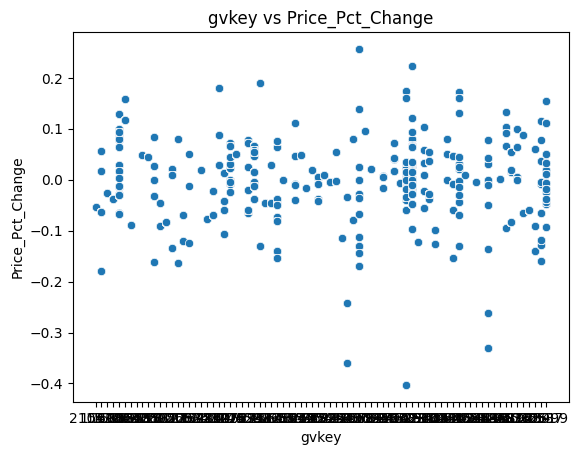

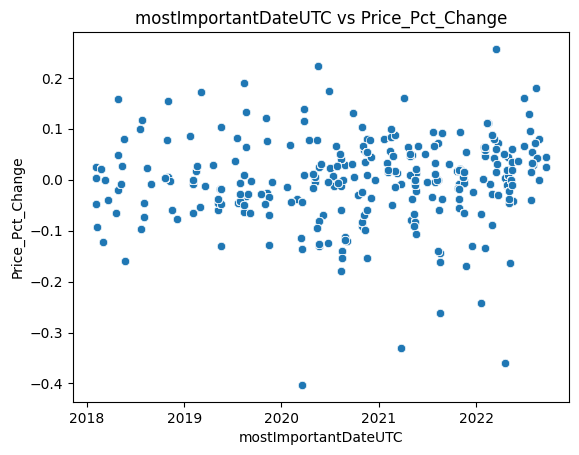

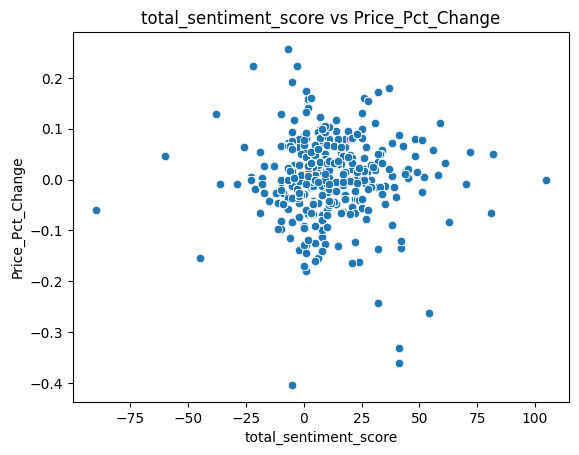

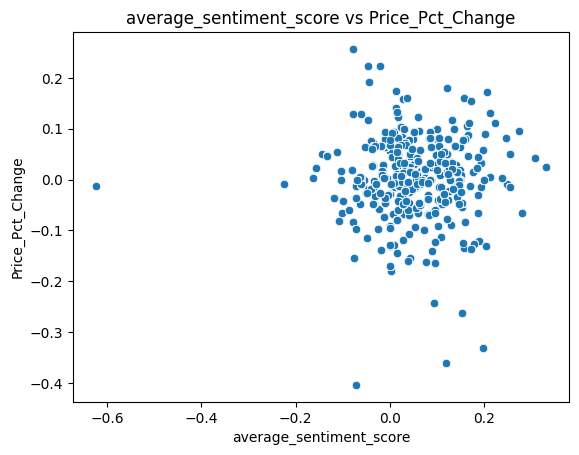

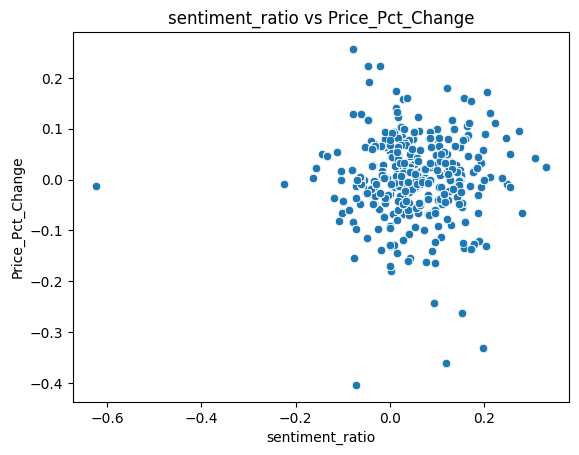

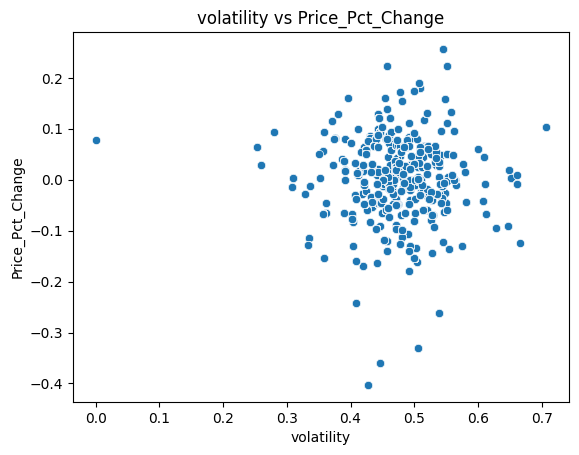


--- revenue ---


TypeError: float() argument must be a string or a real number, not 'NAType'

In [48]:
## CALCULATING CORRELATIONS

# ===== 5. Correlation with price change =====
corr = df_finalized[sentiment_cols + ['Price_Pct_Change']].corr()
print("Correlation with Price_Pct_Change:\n", corr['Price_Pct_Change'].sort_values(ascending=False))

# Scatter plots
for col in sentiment_cols:
    sns.scatterplot(data=df_final, x=col, y='Price_Pct_Change')
    plt.title(f'{col} vs Price_Pct_Change')
    plt.show()

# ===== 6. Correlation with financial metrics =====
financial_cols = ['revenue', 'eps', 'pe_ratio', 'ev_ebitda']

for fin_col in financial_cols:
    print(f'\n--- {fin_col} ---')
    corr = df_final[sentiment_cols + [fin_col]].corr()
    print(corr[fin_col].sort_values(ascending=False))

# ===== 7. Simple OLS regression: sentiment -> price change =====
X = df_final[sentiment_cols]
y = df_final['Price_Pct_Change']
X = sm.add_constant(X)
model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())